# Day_013

### 練習時間
離散化有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline # 內嵌繪圖，並且可以省略掉 plt.show()

In [2]:
# 設定 data_path
dir_data = 'D:/Coding Project/GitHub/ML100-Days/data/Topic_1/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

In [3]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [4]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [5]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False


In [6]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [7]:
# 根據收入分成不同組別 (收入區間 - 還款與否)
cut_rule = [25650.0, 112500.0, 202500.0, 117000000.0]
app_train['AMT_INCOME_TOTAL_GROUP'] = pd.cut(app_train['AMT_INCOME_TOTAL'],
                                             cut_rule, labels = ['Low', 'Medium', 'High'], include_lowest = True)

income_data = app_train[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_INCOME_TOTAL_GROUP']] # subset
print(income_data.groupby('AMT_INCOME_TOTAL_GROUP').size())
income_data.head()

AMT_INCOME_TOTAL_GROUP
Low       100578
Medium    135395
High       71538
dtype: int64


,TARGET,AMT_INCOME_TOTAL,AMT_INCOME_TOTAL_GROUP
0,1,202500.0,Medium
1,0,270000.0,High
2,0,67500.0,Low
3,0,135000.0,Medium
4,0,121500.0,Medium


In [8]:
grp = ['TARGET','AMT_INCOME_TOTAL_GROUP']

grouped_df = income_data.groupby(grp)['AMT_INCOME_TOTAL']  # groupby(['欄位'])['要運算的欄位']
grp_mean = grouped_df.mean()
grp_mean

TARGET  AMT_INCOME_TOTAL_GROUP
0       Low                        90202.630670
        Medium                    158830.090078
        High                      297276.717080
1       Low                        91037.864799
        Medium                    158282.823761
        High                      309949.838357
Name: AMT_INCOME_TOTAL, dtype: float64

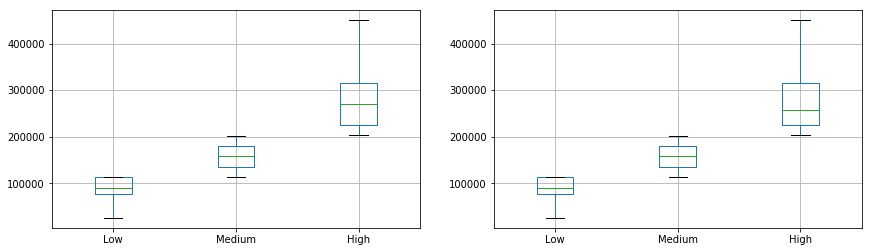

In [9]:
from collections import OrderedDict

Target_0 = income_data[income_data['TARGET'] == 0].groupby(['AMT_INCOME_TOTAL_GROUP'])['AMT_INCOME_TOTAL']
Target_0 = pd.DataFrame(OrderedDict(list(Target_0)))

Target_1 = income_data[income_data['TARGET'] == 1].groupby(['AMT_INCOME_TOTAL_GROUP'])['AMT_INCOME_TOTAL']
Target_1 = pd.DataFrame(OrderedDict(list(Target_1)))

plt.subplots_adjust(right = 2)  # 調整子圖之間的間距
plt.subplot(1,2,1)
Target_0.boxplot(showfliers = False)

plt.subplot(1,2,2)
Target_1.boxplot(showfliers = False)
plt.show()

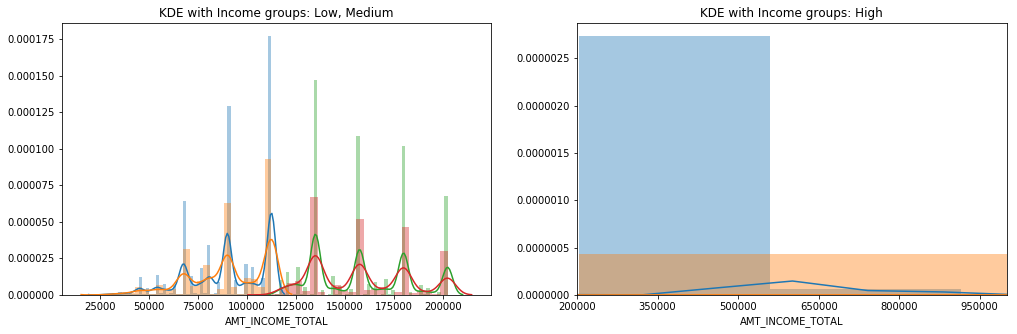

In [10]:
import seaborn as sns # 另一個繪圖-樣式套件

amt_income_total_sorted = income_data['AMT_INCOME_TOTAL_GROUP'].unique().sort_values()
plt.figure(figsize=(7,5))

# 將 bar 與 Kde 同時呈現: distplot，分群比較
plt.subplots_adjust(right = 2)  # 調整子圖之間的間距
plt.subplot(1,2,1)
sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[0]) & \
                             (income_data['TARGET'] == 0), 'AMT_INCOME_TOTAL'])
sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[0]) & \
                             (income_data['TARGET'] == 1), 'AMT_INCOME_TOTAL'])

sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[1]) & \
                             (income_data['TARGET'] == 0), 'AMT_INCOME_TOTAL'])
sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[1]) & \
                             (income_data['TARGET'] == 1), 'AMT_INCOME_TOTAL'])
plt.title('KDE with Income groups: Low, Medium')

plt.subplot(1,2,2)
sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[2]) & \
                             (income_data['TARGET'] == 0), 'AMT_INCOME_TOTAL'])
sns.distplot(income_data.loc[(income_data['AMT_INCOME_TOTAL_GROUP'] == amt_income_total_sorted[2]) & \
                             (income_data['TARGET'] == 1), 'AMT_INCOME_TOTAL'])
my_x_ticks = np.arange(200000, 5000000, 150000) 
plt.xticks(my_x_ticks)
plt.xlim(200000, 1000000)
plt.title('KDE with Income groups: High')

plt.show()